# Clean cho data train và test

In [25]:
import pandas as pd
import io
import re
import numpy as np

In [37]:
def clean_hour(hour_str):
    if isinstance(hour_str, str):
        match = re.match(r'(\d{2}:\d{2})', hour_str)
        return match.group(1) if match else hour_str
    return hour_str

def preprocess(df, visibility_fill_value=None):
    # Clean hour
    df['hour'] = df['hour'].apply(clean_hour)
    
    # Parse date
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day

    # Parse hour
    df['time'] = pd.to_datetime(df['hour'], format='%H:%M', errors='coerce')
    df['hour_value'] = df['time'].dt.hour
    df['minute'] = df['time'].dt.minute

    # Drop temp columns
    df = df.drop(columns=['date', 'hour', 'time'])

    # Clean visibility
    df['visibility'] = pd.to_numeric(df['visibility'], errors='coerce')

    if visibility_fill_value is not None:
        df['visibility'] = df['visibility'].fillna(visibility_fill_value)
    else:
        df['visibility'] = df['visibility'].fillna(method='ffill')
        # Nếu muốn: df['visibility'] = df['visibility'].interpolate(method='linear')

    return df

def simplify_weather(desc):
    desc = str(desc).lower()
    
    if any(keyword in desc for keyword in ["thunder", "storm", "lightning", "tornado", "hurricane"]):
        return "Stormy"
    
    elif any(keyword in desc for keyword in ["rain", "shower", "drizzle", "sprinkle"]):
        return "Rainy"
    
    elif any(keyword in desc for keyword in ["fog", "haze", "mist", "smoke"]):
        return "Foggy"
    
    elif any(keyword in desc for keyword in ["overcast", "broken clouds", "scattered clouds", "mostly cloudy","more clouds than sun"]):
        return "Cloudy"
    
    elif any(keyword in desc for keyword in ["clear", "sunny", "hot", "warm", "mild", "passing clouds","partly cloudy", "low clouds"]):
        return "Clear"
    
    else:
        return "Unknown"


## 1. Clean dữ liệu train

#### Xử lý giá trị trống

In [27]:
# === LOAD & CLEAN TRAIN ===
df_train = pd.read_csv("Raw_data/raw_data_train.csv")
df_train.isnull().sum()

date               0
hour               0
temperature        0
weather           29
wind_speed         4
wind_angle         0
humidity           1
pressure          22
visibility     45366
dtype: int64

In [28]:
df_train = df_train.dropna(subset=['weather', 'pressure', 'humidity', 'wind_speed', 'temperature'])
df_train.isnull().sum()

date               0
hour               0
temperature        0
weather            0
wind_speed         0
wind_angle         0
humidity           0
pressure           0
visibility     45357
dtype: int64

In [29]:
df_train = preprocess(df_train)

# Đơn giản hóa mô tả thời tiết
df_train['weather'] = df_train['weather'].apply(simplify_weather)

# Ghi lại giá trị visibility fill từ tập train (dùng giá trị gần nhất không null cuối cùng)
visibility_fill_value = df_train['visibility'].dropna().iloc[-1]

# Lưu dữ liệu đã xử lý
df_train = df_train[['year', 'month', 'day', 'hour_value', 'minute', 'weather', 'temperature', 
                     'wind_speed', 'wind_angle', 'humidity', 'pressure', 'visibility']]
df_train.head()

C:\Users\nptha\AppData\Local\Temp\ipykernel_21824\2670348704.py:31: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['visibility'] = df['visibility'].fillna(method='ffill')


,year,month,day,hour_value,minute,weather,temperature,wind_speed,wind_angle,humidity,pressure,visibility
0,2019,1,1,0,0,Clear,19.0,6.0,300.0,88.0,1023.0,6.0
1,2019,1,1,0,30,Clear,19.0,4.0,310.0,88.0,1023.0,6.0
2,2019,1,1,1,0,Clear,19.0,6.0,300.0,88.0,1022.0,6.0
3,2019,1,1,1,30,Clear,19.0,6.0,310.0,88.0,1022.0,6.0
4,2019,1,1,2,0,Clear,19.0,9.0,310.0,88.0,1022.0,6.0


In [30]:
# Áp dụng hàm vào dữ liệu và lọc ra các mô tả chưa được phân loại (Unknown)
df_train['weather_simplified'] = df_train['weather'].apply(simplify_weather)
unknown_weather = df_train[df_train['weather_simplified'] == 'Unknown']['weather'].value_counts()
unknown_weather

weather
Cloudy    11932
Name: count, dtype: int64

#### Xử lý outliers

In [31]:
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
    return outliers

for col in ['temperature', 'wind_speed', 'wind_angle', 'humidity', 'pressure', 'visibility']:
    print(f'Outliers in {col}:', detect_outliers(df_train, col).count())

Outliers in temperature: 56
Outliers in wind_speed: 2518
Outliers in wind_angle: 0
Outliers in humidity: 353
Outliers in pressure: 36
Outliers in visibility: 18243


| Biến         | Số lượng outliers | Tỷ lệ (%) | Xử lý                                 |
|--------------|-------------------|-----------|----------------------------------------|
| temperature  | 56                | 0.07%     | Không cần xử lý (quá ít)               |
| wind_speed   | 2,518             | 3.07%     | Xử lý biến đổi giới hạn          |
| wind_angle   | 0                 | 0.00%     | Không cần làm gì                       |
| humidity     | 353               | 0.43%     | Không cần xử lý                        |
| pressure     | 36                | 0.04%     | Không cần xử lý                        |
| visibility   | 18,243            | 22.25%    | Cần xử lý, chiếm hơn 1/5 dữ liệu       |


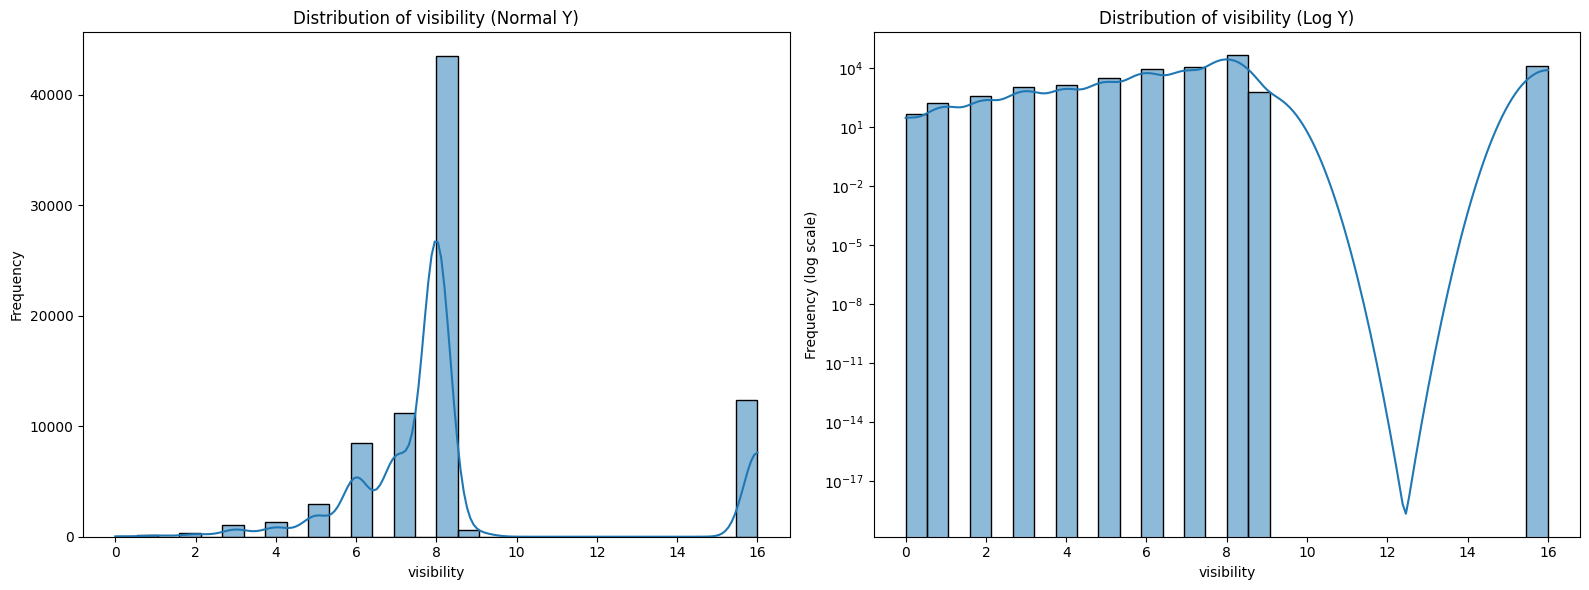

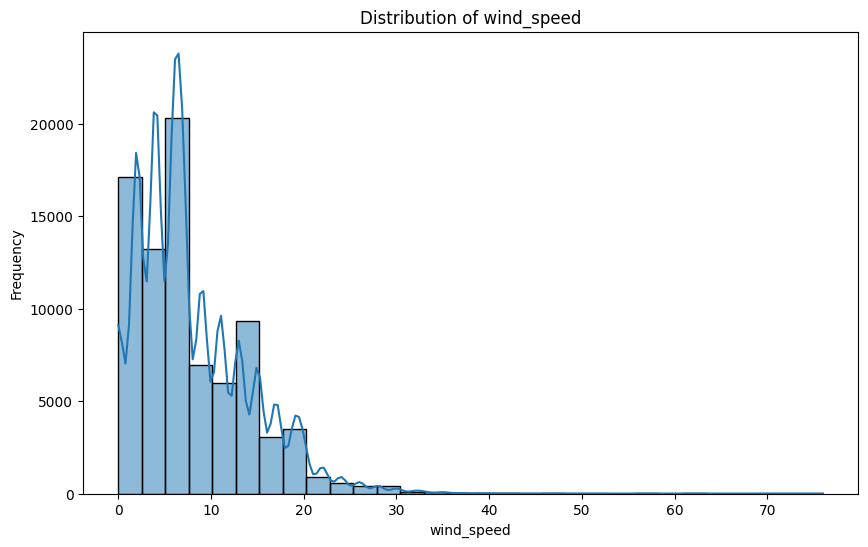

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Vẽ biểu đồ phân phối cho các biến số
def plot_distribution(df, column):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column], bins=30, kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

def plot_distribution_log(df, column):
    plt.figure(figsize=(16, 6))

    # Biểu đồ thường
    plt.subplot(1, 2, 1)
    sns.histplot(df[column], bins=30, kde=True)
    plt.title(f'Distribution of {column} (Normal Y)')
    plt.xlabel(column)
    plt.ylabel('Frequency')

    # Biểu đồ với log trục Y
    plt.subplot(1, 2, 2)
    sns.histplot(df[column], bins=30, kde=True)
    plt.yscale('log')
    plt.title(f'Distribution of {column} (Log Y)')
    plt.xlabel(column)
    plt.ylabel('Frequency (log scale)')

    plt.tight_layout()
    plt.show()

plot_distribution_log(df_train, 'visibility')
plot_distribution(df_train, 'wind_speed')

In [33]:
# 1. Winsorize wind_speed (giới hạn trong khoảng [Q1 - 1.5*IQR, Q3 + 1.5*IQR])
Q1_ws = df_train['wind_speed'].quantile(0.25)
Q3_ws = df_train['wind_speed'].quantile(0.75)
IQR_ws = Q3_ws - Q1_ws
lower_ws = Q1_ws - 1.5 * IQR_ws
upper_ws = Q3_ws + 1.5 * IQR_ws
df_train['wind_speed'] = np.clip(df_train['wind_speed'], lower_ws, upper_ws)

# 2. Log transform visibility để giảm ảnh hưởng của outliers
df_train['visibility_log'] = np.log1p(df_train['visibility'])  # log(1 + x), tránh log(0)

df_train.drop(columns=['weather_simplified'], inplace=True)  # Xóa cột visibility gốc
df_train.head()

,year,month,day,hour_value,minute,weather,temperature,wind_speed,wind_angle,humidity,pressure,visibility,visibility_log
0,2019,1,1,0,0,Clear,19.0,6.0,300.0,88.0,1023.0,6.0,1.94591
1,2019,1,1,0,30,Clear,19.0,4.0,310.0,88.0,1023.0,6.0,1.94591
2,2019,1,1,1,0,Clear,19.0,6.0,300.0,88.0,1022.0,6.0,1.94591
3,2019,1,1,1,30,Clear,19.0,6.0,310.0,88.0,1022.0,6.0,1.94591
4,2019,1,1,2,0,Clear,19.0,9.0,310.0,88.0,1022.0,6.0,1.94591


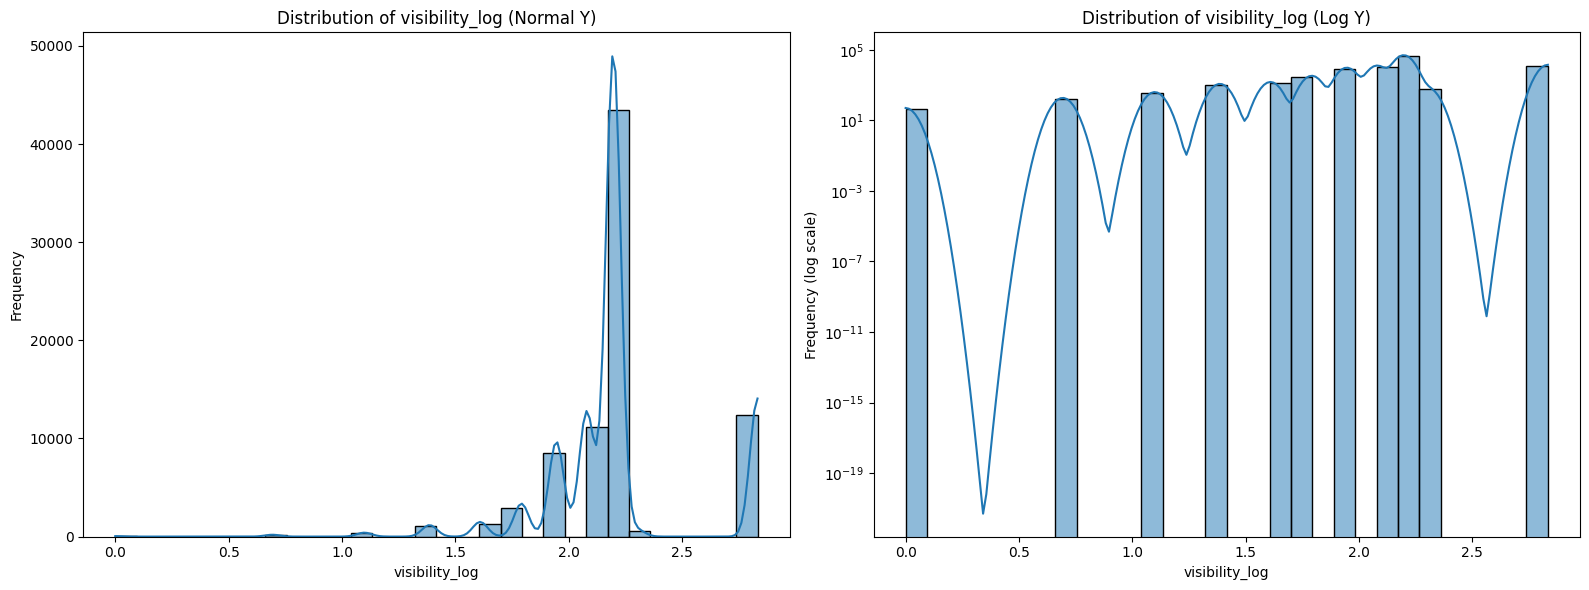

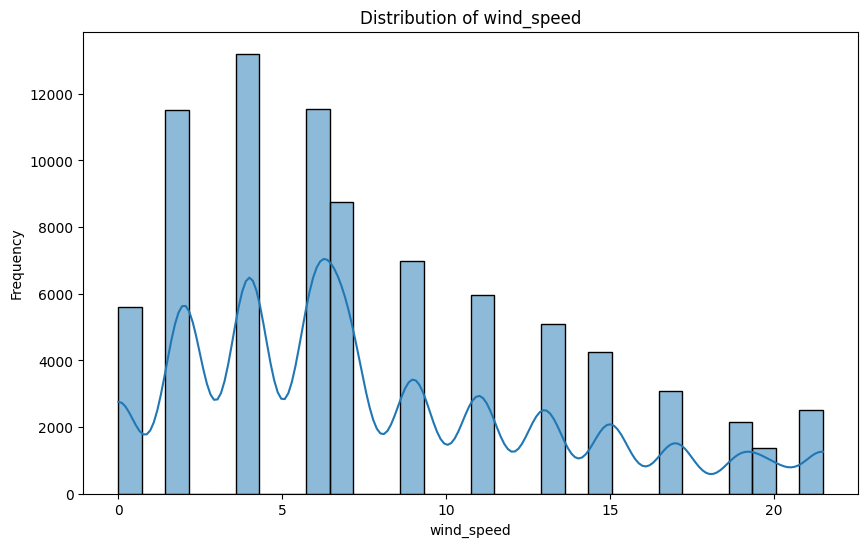

In [34]:
# Vẽ biểu đồ phân phối cho các biến số sau khi xử lý
plot_distribution_log(df_train, 'visibility_log')
plot_distribution(df_train, 'wind_speed')

In [35]:
# Convert time-related features to cyclical
df_train['hour_sin'] = np.sin(2 * np.pi * df_train['hour_value'] / 24)
df_train['hour_cos'] = np.cos(2 * np.pi * df_train['hour_value'] / 24)
df_train['minute_sin'] = np.sin(2 * np.pi * df_train['minute'] / 60)
df_train['minute_cos'] = np.cos(2 * np.pi * df_train['minute'] / 60)
df_train['month_sin'] = np.sin(2 * np.pi * df_train['month'] / 12)
df_train['month_cos'] = np.cos(2 * np.pi * df_train['month'] / 12)

# Convert wind direction and speed into vector components
df_train['wind_angle_rad'] = np.radians(df_train['wind_angle'])
df_train['wind_u'] = df_train['wind_speed'] * np.sin(df_train['wind_angle_rad'])  # East-West component
df_train['wind_v'] = df_train['wind_speed'] * np.cos(df_train['wind_angle_rad'])  # North-South component
df_train.head()

,year,month,day,hour_value,minute,weather,temperature,wind_speed,wind_angle,humidity,...,visibility_log,hour_sin,hour_cos,minute_sin,minute_cos,month_sin,month_cos,wind_angle_rad,wind_u,wind_v
0,2019,1,1,0,0,Clear,19.0,6.0,300.0,88.0,...,1.94591,0.000000,1.000000,0.000000e+00,1.0,0.5,0.866025,5.235988,-5.196152,3.000000
1,2019,1,1,0,30,Clear,19.0,4.0,310.0,88.0,...,1.94591,0.000000,1.000000,5.665539e-16,-1.0,0.5,0.866025,5.410521,-3.064178,2.571150
2,2019,1,1,1,0,Clear,19.0,6.0,300.0,88.0,...,1.94591,0.258819,0.965926,0.000000e+00,1.0,0.5,0.866025,5.235988,-5.196152,3.000000
3,2019,1,1,1,30,Clear,19.0,6.0,310.0,88.0,...,1.94591,0.258819,0.965926,5.665539e-16,-1.0,0.5,0.866025,5.410521,-4.596267,3.856726
4,2019,1,1,2,0,Clear,19.0,9.0,310.0,88.0,...,1.94591,0.500000,0.866025,0.000000e+00,1.0,0.5,0.866025,5.410521,-6.894400,5.785088


In [36]:
df_train.to_csv("Clean_data/clean_data_train.csv", index=False)

## 2. Clean dữ liệu test với tham số đa sử dụng cho train trước đó

In [38]:
# === LOAD & CLEAN TEST ===
df_test = pd.read_csv("Raw_data/raw_data_test.csv")
df_test.isnull().sum()

date               0
hour               0
temperature        0
weather            0
wind_speed         0
wind_angle         0
humidity           0
pressure           1
visibility     17099
dtype: int64

In [39]:
df_test = df_test.dropna(subset=['weather', 'pressure', 'humidity', 'wind_speed', 'temperature'])
df_test.isnull().sum()

date               0
hour               0
temperature        0
weather            0
wind_speed         0
wind_angle         0
humidity           0
pressure           0
visibility     17099
dtype: int64

In [40]:
df_test = preprocess(df_test, visibility_fill_value=visibility_fill_value)
df_test['weather'] = df_test['weather'].apply(simplify_weather)
df_test = df_test[['year', 'month', 'day', 'hour_value', 'minute', 'weather', 'temperature', 
                   'wind_speed', 'wind_angle', 'humidity', 'pressure', 'visibility']]
df_test.head()

,year,month,day,hour_value,minute,weather,temperature,wind_speed,wind_angle,humidity,pressure,visibility
0,2024,1,1,0,0,Foggy,22.0,4.0,320.0,100.0,1017.0,5.0
1,2024,1,1,0,30,Foggy,23.0,2.0,340.0,94.0,1017.0,5.0
2,2024,1,1,1,0,Foggy,22.0,2.0,320.0,100.0,1016.0,5.0
3,2024,1,1,1,30,Foggy,22.0,2.0,0.0,94.0,1016.0,5.0
4,2024,1,1,2,0,Foggy,22.0,4.0,320.0,100.0,1016.0,5.0


In [41]:
df_test.isnull().sum()

year           0
month          0
day            0
hour_value     0
minute         0
weather        0
temperature    0
wind_speed     0
wind_angle     0
humidity       0
pressure       0
visibility     0
dtype: int64

In [37]:
# 1. Winsorize wind_speed (giới hạn trong khoảng [Q1 - 1.5*IQR, Q3 + 1.5*IQR] của tập train)
df_test['wind_speed'] = np.clip(df_test['wind_speed'], lower_ws, upper_ws)

# 2. Log transform visibility để giảm ảnh hưởng của outliers
df_test['visibility_log'] = np.log1p(df_test['visibility'])  # log(1 + x), tránh log(0)

df_test.head()

,year,month,day,hour_value,minute,weather,temperature,wind_speed,wind_angle,humidity,pressure,visibility,visibility_log
0,2024,1,1,0,0,Foggy,22.0,4.0,320.0,100.0,1017.0,5.0,1.791759
1,2024,1,1,0,30,Foggy,23.0,2.0,340.0,94.0,1017.0,5.0,1.791759
2,2024,1,1,1,0,Foggy,22.0,2.0,320.0,100.0,1016.0,5.0,1.791759
3,2024,1,1,1,30,Foggy,22.0,2.0,0.0,94.0,1016.0,5.0,1.791759
4,2024,1,1,2,0,Foggy,22.0,4.0,320.0,100.0,1016.0,5.0,1.791759


In [42]:
# Convert time-related features to cyclical
df_test['hour_sin'] = np.sin(2 * np.pi * df_test['hour_value'] / 24)
df_test['hour_cos'] = np.cos(2 * np.pi * df_test['hour_value'] / 24)
df_test['minute_sin'] = np.sin(2 * np.pi * df_test['minute'] / 60)
df_test['minute_cos'] = np.cos(2 * np.pi * df_test['minute'] / 60)
df_test['month_sin'] = np.sin(2 * np.pi * df_test['month'] / 12)
df_test['month_cos'] = np.cos(2 * np.pi * df_test['month'] / 12)

# Convert wind direction and speed into vector components
df_test['wind_angle_rad'] = np.radians(df_test['wind_angle'])
df_test['wind_u'] = df_test['wind_speed'] * np.sin(df_test['wind_angle_rad'])  # East-West component
df_test['wind_v'] = df_test['wind_speed'] * np.cos(df_test['wind_angle_rad'])  # North-South component
df_test.head()

,year,month,day,hour_value,minute,weather,temperature,wind_speed,wind_angle,humidity,...,visibility,hour_sin,hour_cos,minute_sin,minute_cos,month_sin,month_cos,wind_angle_rad,wind_u,wind_v
0,2024,1,1,0,0,Foggy,22.0,4.0,320.0,100.0,...,5.0,0.000000,1.000000,0.000000e+00,1.0,0.5,0.866025,5.585054,-2.571150,3.064178
1,2024,1,1,0,30,Foggy,23.0,2.0,340.0,94.0,...,5.0,0.000000,1.000000,5.665539e-16,-1.0,0.5,0.866025,5.934119,-0.684040,1.879385
2,2024,1,1,1,0,Foggy,22.0,2.0,320.0,100.0,...,5.0,0.258819,0.965926,0.000000e+00,1.0,0.5,0.866025,5.585054,-1.285575,1.532089
3,2024,1,1,1,30,Foggy,22.0,2.0,0.0,94.0,...,5.0,0.258819,0.965926,5.665539e-16,-1.0,0.5,0.866025,0.000000,0.000000,2.000000
4,2024,1,1,2,0,Foggy,22.0,4.0,320.0,100.0,...,5.0,0.500000,0.866025,0.000000e+00,1.0,0.5,0.866025,5.585054,-2.571150,3.064178


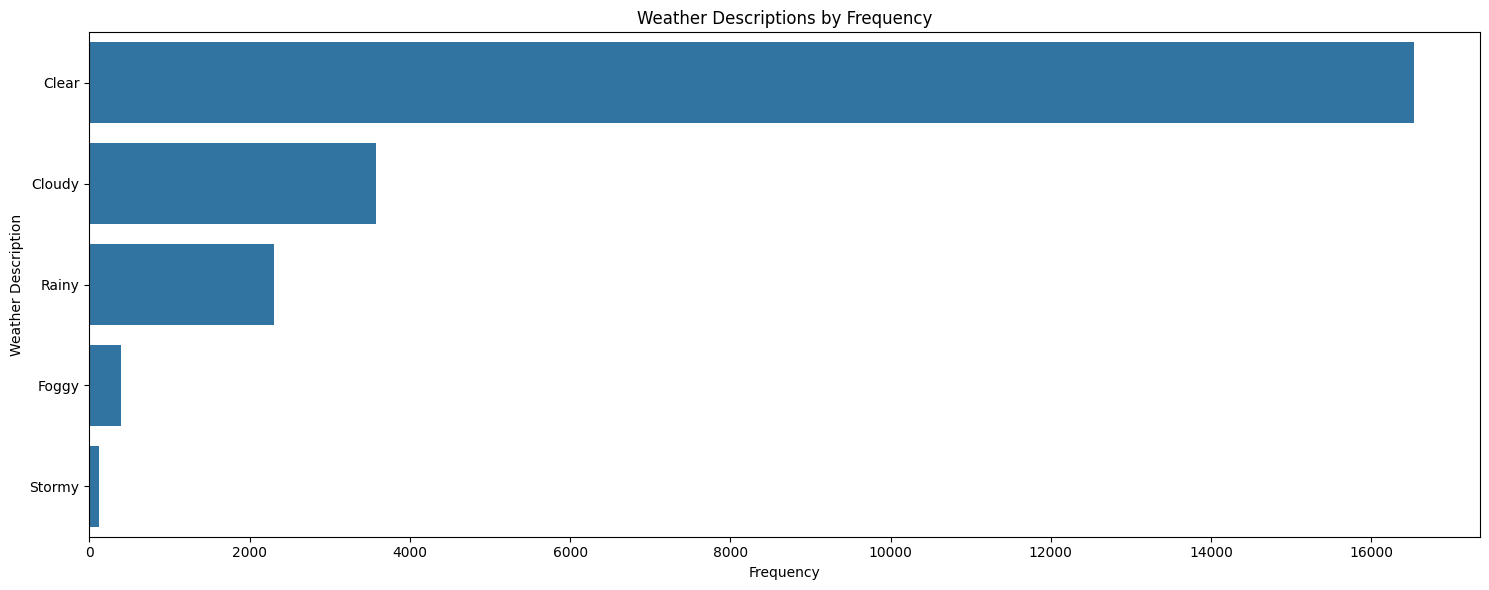

In [43]:
# Vẽ biểu đồ tần suất cho các giá trị weather
plt.figure(figsize=(15, 6))
weather_counts = df_test['weather'].value_counts().head(20)
sns.barplot(x=weather_counts.values, y=weather_counts.index)
plt.title('Weather Descriptions by Frequency')
plt.xlabel('Frequency')
plt.ylabel('Weather Description')
plt.tight_layout()
plt.show()

In [44]:
df_test.to_csv("Clean_data/clean_data_test.csv", index=False)

In [45]:
print("✅ Hoàn tất xử lý dữ liệu train và test.")

✅ Hoàn tất xử lý dữ liệu train và test.
